# Modelling Antibiotics Resistance through virtual simulations
authors: Talhah Peerbhai (talhah@cmu.edu), Hanna Qasim (hqasim@andrew.cmu.edu)

In [115]:
# Run this to initialize the model
import importlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Due to the nature of jupyter it doesn't take into account the code outside changing unless kernel restarted
# this is a workaround as per https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
imported_module = importlib.import_module("simulation_model.simulation_model")
importlib.reload(imported_module)
from simulation_model.simulation_model import *

params = {
    # Environmental parameters
    "width": 10,
    "height": 10,
    "diffusion_coefficient": 0.1,
    # Bacterium parameters
    "num_agents": 10,
    "nutrient_intake": 1,
    "antibiotic_intake": 1,
    "biomass_threshold": 10,
    "initial_size": 10,
    "initial_biomass": 0.1,
    "lag_phase": 66,
}

model = SimModel(params)

/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:83: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  class SimModel(mesa.Model):


### View Nutrient distribution

Currently there are 100.0 nutrients


[Text(0.5, 1.0, 'Nutrient distribution')]

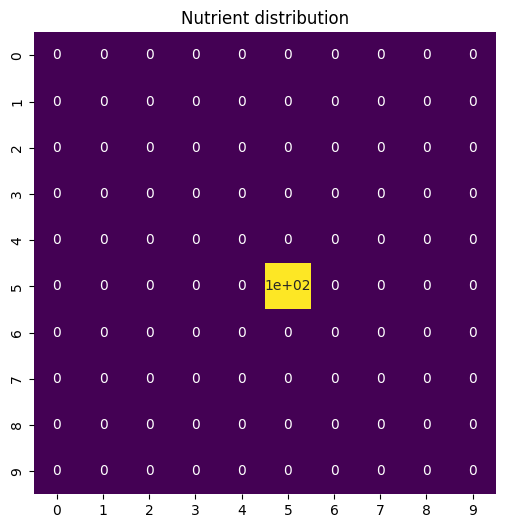

In [108]:
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]

print(f"Currently there are {amount} nutrients")
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(6, 6)
g.set(title="Nutrient distribution")

### View Nutrient distribution over time with animation

In [116]:
def update(frame_number, nutrient_counts, model, fig, ax):
    ax.clear()  # Clear current axis to redraw
    amount = 0
    for cell_content, (x, y) in model.grid.coord_iter():
        amount += model.grid.properties["nutrient"].data[x][y]
        nutrient_counts[x,y] = model.grid.properties["nutrient"].data[x][y]
    
    sns.heatmap(nutrient_counts, cmap="viridis", annot=True, 
                cbar=False, square=True, ax=ax)
    
    ax.set(title=f"Nutrient distribution at step {frame_number + 1}\nTotal nutrients: {amount}")

    model.step()

nutrient_counts = np.zeros((model.grid.width, model.grid.height))
fig, ax = plt.subplots(figsize=(6, 6))

# Animation function, range will determine how many steps are taken
ani = FuncAnimation(fig, update, frames=range(50), fargs=(nutrient_counts, model, fig, ax), 
                    interval=200, repeat=False)

plt.close()
# Save animation, REQUIRES FFMPEG which is standard on most linux distros
ani.save('nutrient_spread.mp4', writer='ffmpeg')
# If this fails then run this and ensure you have pillow with pip install pillow, ask me for help if it still doesn't work
# ani.save('nutrient_spread.gif', writer='pillow')  # Save as GIF

### View Agent distribution

[Text(0.5, 1.0, 'Agent Distribution')]

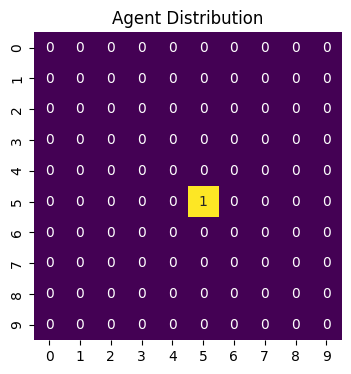

In [105]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
f = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
f.figure.set_size_inches(4, 4)
f.set(title="Agent Distribution")

### Step Through model

In [ ]:
for _ in range(100):
    model.step()